### Instructions
1.  Build the best decision tree you can.
2.  Build the simplest random forest you can.
3.  Compare the runtime of the decision tree and random forest

### 1 - Loading the Dataset
This dataset has 20 features ranging from customer demographics, services bought, and account information.  The purpose is to find out if the customer churned or not in the past month.  With 21 columns and ~7000 columns, I expect computational times to be quick for decision trees and random forests.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, r2_score, roc_curve
import time

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### 2 - Exploring the Data
Data exploration will be split into three parts: churn, numerical features, and categorical features.

####  2.1 - Churn
In this dataset, we see that the majority of customers, about 75%, did not churn in the last month.  Decision trees and random forests are robust, but it would be good to test if any under or oversampling will need to be done to increase accuracy.  Lastly, since trees need numerical inputs, I map 'No' to 0 and 'Yes' to 1.  

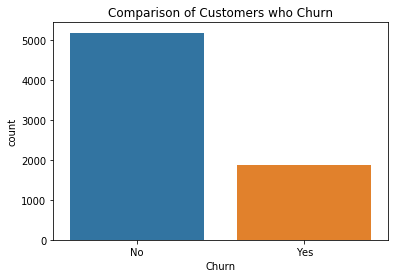

In [6]:
sns.countplot(x = 'Churn', data = df)
plt.title('Comparison of Customers who Churn')

In [7]:
df[df['Churn']=='No'].shape[0]/df.shape[0]*100

73.4630129206304

In [8]:
df['Churn'] = df['Churn'].map({'No':0, 'Yes': 1})

#### 2.2 - Numerical
There are three numerical features: tenure, total and monthly charges.  Tenure is the number of months a customer has been with the company.  The two charges are more obvious, where monthly charge is how much the customer is paying per month, and total charges is how much the customer has paid over the course of their time with the company.  As such, I expect there to be a positive relationship between tenure and total charges.  

The distribution for tenure is interesting, involving a bimodal model with two peaks at ~5 (indicating new customers) and at ~70 months (~6 years, indicating the longest customers).  Monthly charges also has a bimodal distribution, with a peak at ~\$20 and another at ~\$80.  This indicates there are probably two types of customers or packages, where one group has the bare minimum and the other has almost all the services.  Lastly, total charges is strongly right skewed, with a prominent peak under $500.  

In [9]:
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: 0 if x == ' ' else float(x))

In [10]:
num_col = ['tenure', 'MonthlyCharges', 'TotalCharges']

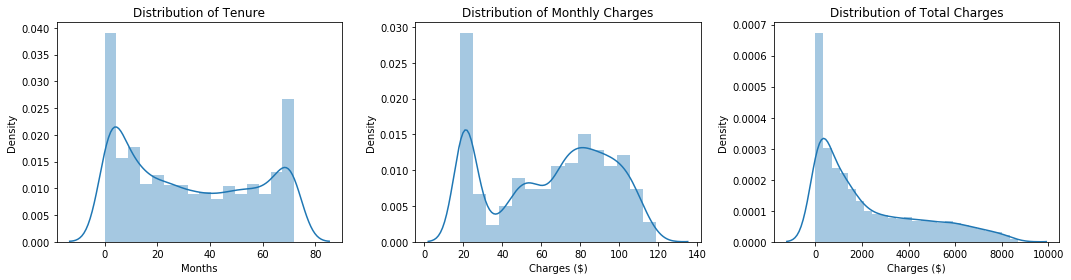

In [11]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(15, 4))

sns.distplot(df['tenure'], ax = axis1)
sns.distplot(df['MonthlyCharges'], bins = 15, ax = axis2)
sns.distplot(df['TotalCharges'], ax = axis3)

axis1.set_title('Distribution of Tenure')
axis2.set_title('Distribution of Monthly Charges')
axis3.set_title('Distribution of Total Charges')

axis1.set_xlabel('Months')
axis2.set_xlabel('Charges ($)')
axis3.set_xlabel('Charges ($)')

for ax in [axis1, axis2, axis3]:
    ax.set_ylabel('Density')
plt.tight_layout()

##### 2.2.1 - Numeric Features and Relationship to Churn
As suspected, total charges and tenure have a positive relationship, as seen in the scatterplot on the bottom left of the pair plot.  More importantly though, is that we can see in the distribution plots for tenure and monthly charge the difference between customers who churn and don't churn.  For customers who churn, most likely they are new customers and have high monthly charges.  There doesn't seem to be a clear cut way to distinguish between customers who churn and doesn't churn from the total charges.

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


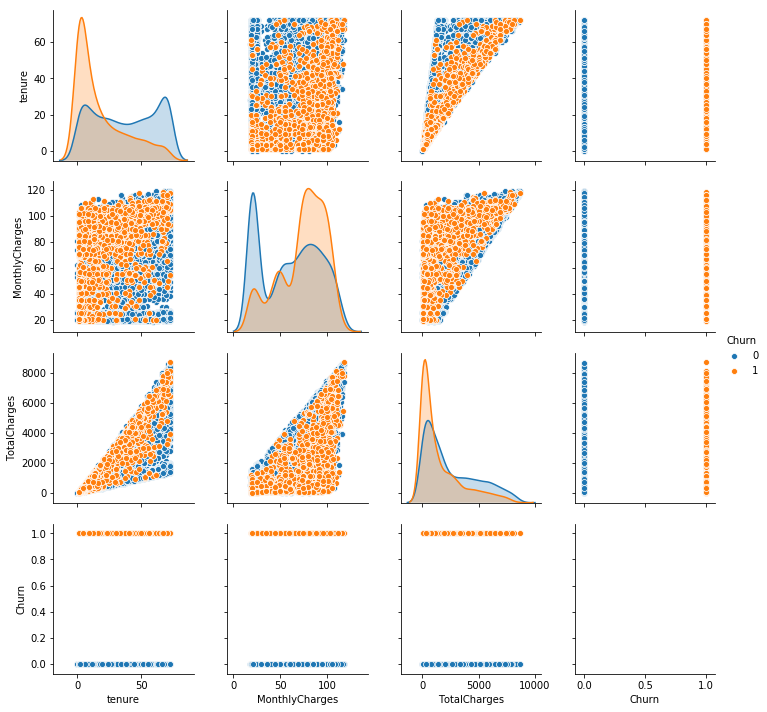

In [12]:
sns.pairplot(pd.concat([df[num_col], df['Churn']], axis = 1), hue = 'Churn')

#### 2.3 - Categorical
For the categorical features, I will split them up into demographics and services, and account information.

##### 2.3.1 - Demographics
The demographic information we have are gender (male/female), if they are a senior citizen, and have a partner or dependents.  Gender seemed to have no bearing on if a customer churned or not.  However, if the customer was a senior citizen, they had a higher chance of churning, as did those without partner and dependents.  

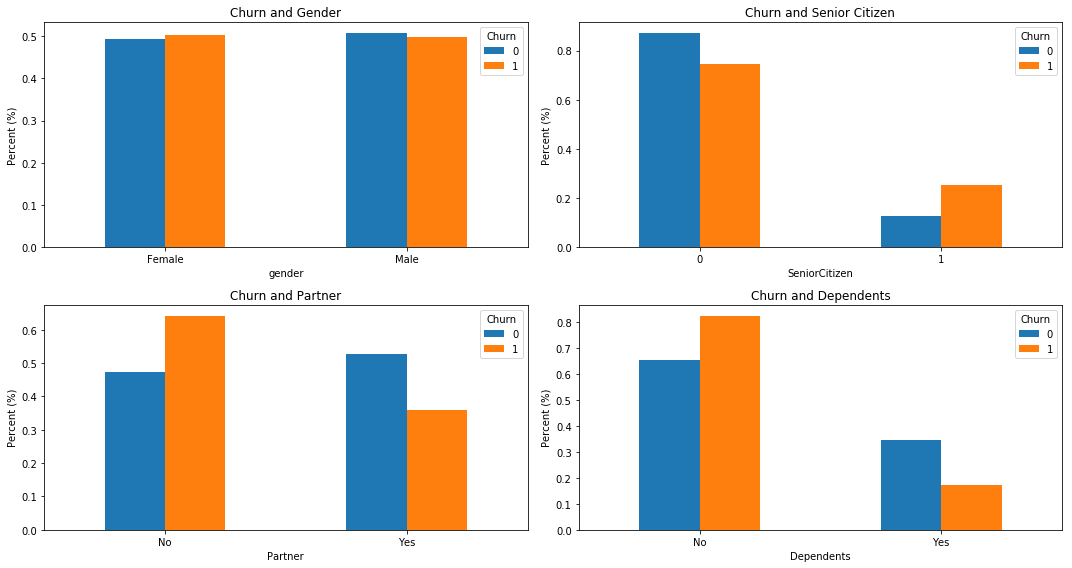

In [13]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2, 2, figsize=(15, 8))

(df.groupby(['gender', 'Churn']).count().unstack()['tenure']/[df[df['Churn']==0].shape[0], 
                                                                     df[df['Churn']==1].shape[0]]).plot(kind = 'bar', ax = axis1)
(df.groupby(['SeniorCitizen', 'Churn']).count().unstack()['tenure']/[df[df['Churn']==0].shape[0], 
                                                                     df[df['Churn']==1].shape[0]]).plot(kind = 'bar', ax = axis2)
(df.groupby(['Partner', 'Churn']).count().unstack()['tenure']/[df[df['Churn']==0].shape[0], 
                                                                     df[df['Churn']==1].shape[0]]).plot(kind = 'bar', ax = axis3)
(df.groupby(['Dependents', 'Churn']).count().unstack()['tenure']/[df[df['Churn']==0].shape[0], 
                                                                     df[df['Churn']==1].shape[0]]).plot(kind = 'bar', ax = axis4)

axis1.set_title('Churn and Gender')
axis2.set_title('Churn and Senior Citizen')
axis3.set_title('Churn and Partner')
axis4.set_title('Churn and Dependents')

for ax in [axis1, axis2, axis3, axis4]:
    ax.set_ylabel('Percent (%)')
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
plt.tight_layout()

##### 2.3.2 - Services
There are multiple types of services a customer can choose from regarding phone and internet options.  In terms of phone service and how many lines the customer has, there isn't much to distinguish between churn and non churning customers.  With the internet services, which includes type of internet, various security/backup plans, tech support and movie streaming capabilities, it seems that overall if the customer does not have these services they are more likely to churn.  The only service that doesn't fall into this pattern is the movie streaming service, where it appears that those with and without movie streaming had the same percentage of people churning.  

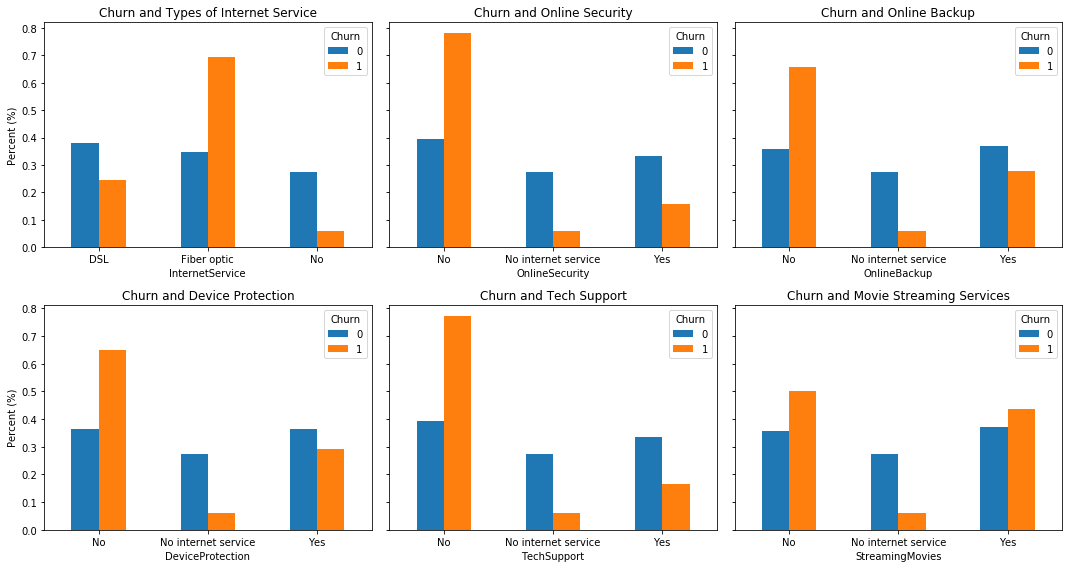

In [14]:
fig, ((axis1, axis2, axis3), (axis4, axis5, axis6)) = plt.subplots(2, 3, sharey = 'row',  figsize=(15, 8))


(df.groupby(['InternetService', 'Churn']).count().unstack()['tenure']/[df[df['Churn']==0].shape[0], 
                                                                     df[df['Churn']==1].shape[0]]).plot(kind = 'bar', ax = axis1)
(df.groupby(['OnlineSecurity', 'Churn']).count().unstack()['tenure']/[df[df['Churn']==0].shape[0], 
                                                                     df[df['Churn']==1].shape[0]]).plot(kind = 'bar', ax = axis2)
(df.groupby(['OnlineBackup', 'Churn']).count().unstack()['tenure']/[df[df['Churn']==0].shape[0], 
                                                                     df[df['Churn']==1].shape[0]]).plot(kind = 'bar', ax = axis3)
(df.groupby(['DeviceProtection', 'Churn']).count().unstack()['tenure']/[df[df['Churn']==0].shape[0], 
                                                                     df[df['Churn']==1].shape[0]]).plot(kind = 'bar', ax = axis4)
(df.groupby(['TechSupport', 'Churn']).count().unstack()['tenure']/[df[df['Churn']==0].shape[0], 
                                                                     df[df['Churn']==1].shape[0]]).plot(kind = 'bar', ax = axis5)
(df.groupby(['StreamingMovies', 'Churn']).count().unstack()['tenure']/[df[df['Churn']==0].shape[0], 
                                                                     df[df['Churn']==1].shape[0]]).plot(kind = 'bar', ax = axis6)

axis1.set_title('Churn and Types of Internet Service')
axis2.set_title('Churn and Online Security')
axis3.set_title('Churn and Online Backup')
axis4.set_title('Churn and Device Protection')
axis5.set_title('Churn and Tech Support')
axis6.set_title('Churn and Movie Streaming Services')


for ax in [axis1, axis2, axis3, axis4, axis5, axis6]:
    ax.set_ylabel('Percent (%)')
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
plt.tight_layout()

##### 2.3.3 - Account Info
We have three types of information regarding account information: contract type, if the customer has paperless billing, and payment method.  Not surprisingly, those with month to month types of contracts are far more likely to churn than those with one or two year contracts (those pesky fees work!).  What I do find surprising is that those with paperless billing and pay by electronic check are more likely to churn.  

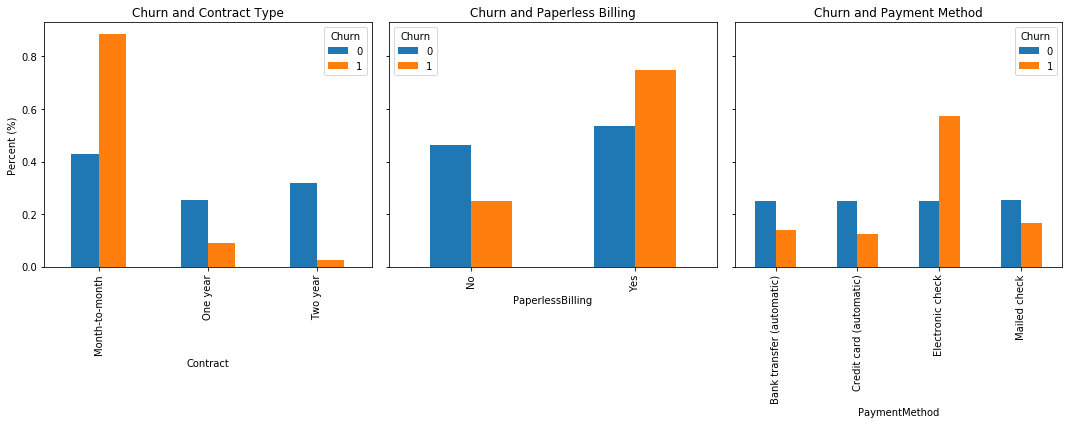

In [15]:
fig, ((axis1, axis2, axis3)) = plt.subplots(1, 3, sharey = 'row', figsize=(15, 6))

(df.groupby(['Contract', 'Churn']).count().unstack()['tenure']/[df[df['Churn']==0].shape[0], 
                                                                     df[df['Churn']==1].shape[0]]).plot(kind = 'bar', ax = axis1)
(df.groupby(['PaperlessBilling', 'Churn']).count().unstack()['tenure']/[df[df['Churn']==0].shape[0], 
                                                                     df[df['Churn']==1].shape[0]]).plot(kind = 'bar', ax = axis2)
(df.groupby(['PaymentMethod', 'Churn']).count().unstack()['tenure']/[df[df['Churn']==0].shape[0], 
                                                                     df[df['Churn']==1].shape[0]]).plot(kind = 'bar', ax = axis3)

axis1.set_title('Churn and Contract Type')
axis2.set_title('Churn and Paperless Billing')
axis3.set_title('Churn and Payment Method')

for ax in [axis1, axis2, axis3]:
    ax.set_ylabel('Percent (%)')
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
plt.tight_layout()

### 3 - Decision Tree
Its finally time to apply a decision tree to the data!  For the first tree, I will make it as basic as possible to get a baseline result. First though, I need to change everything to numeric values.  The mean cv score comes out to be 71.5%.  This is a poor result, as just choosing 0/not churn for the training set will get ~74% accuracy.  

In [16]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes

Now that everything is numeric, I can apply the decision tree.  With a 5 fold cross validation model and default hyperparameters, the decision tree has a mean accuracy of 71.8%, with a variance of ~4%.  

In [17]:
X = df.drop('Churn', axis = 1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
decision_tree1 = tree.DecisionTreeClassifier(random_state=42)
decision_tree1.fit(X_train, y_train)
cv1 = cross_val_score(decision_tree1, X_train, y_train, cv = 5)
print('Mean CV scores is {:.3f}, with CV scores: {}'.format(cv1.mean(), cv1))

Mean CV scores is 0.718, with CV scores: [ 0.73415326  0.69820246  0.70833333  0.73863636  0.7092803 ]


In [59]:
1-y_train.sum()/len(y_train)

0.73684210526315796

### 4 - Improving the Decision Tree


#### 4.1 - Feature Engineering
So far, I haven't done any feature engineering.  Based on the data exploration phase, I suspect that adding up the number of services a customer has can tell us if they will churn or not.  

In [25]:
df['num_services'] = df['OnlineSecurity'] + df['OnlineBackup'] + df['DeviceProtection'] + df['TechSupport']

In addition, I can one hot encode categorical features with less than 5 unique values.  

In [27]:
dummy_df = pd.DataFrame()
for col in ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
            'PaperlessBilling', 'PaymentMethod']:
    dummy_df = pd.concat([dummy_df, pd.get_dummies(df[col], prefix=col, drop_first=True)], axis = 1)

In [ ]:
df2 = pd.concat([dummy_df, df[['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']]], axis = 1)

##### 4.2 - Optimizing Hyperparameters
The other thing I can do to improve the decision tree is to optimize the hyperparameters.  For decision trees, the main hyperparameters to tune are max features, max depth, min samples split, and min samples leaf.  

To help me narrow down the values for each hyperparmeter, I will use random grid search.

In [46]:
random_grid = {'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [3, 5,7,10, 12, 15, 17, 20],
               'min_samples_split': [2, 5, 10, 13, 15, 18, 20, 22, 25, 27, 30],
               'min_samples_leaf': [2, 4, 6, 8, 10, 12, 15, 17, 20, 22, 25, 27, 30]}

In [47]:
decision_tree_rand = RandomizedSearchCV(decision_tree1, random_grid)
best_dt_rand = decision_tree_rand.fit(X_train, y_train)
print('Mean accuracy of random grid search: {}'.format(best_dt_rand.score(X_train, y_train)))

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Mean accuracy of random grid search: 0.8180613404013631


In [48]:
best_dt_rand.best_params_

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 17,
 'min_samples_split': 20}

The random grid search spit out a set of hyperparameters that had ~81% accuracy.  I then use grid search to narrow down which values give the best accuracy.  In this case, I come up with a max depth of 13, max features at auto, min samples leaf at 17, and min samples split at 16.  The accuracy of the training set is also ~81%.  

In [51]:
param_grid = {'max_features': ['auto'],
               'max_depth': [12, 13, 14, 15, 16, 17, 18],
               'min_samples_split': [16, 17, 18, 19, 20, 21, 22, 21, 24],
               'min_samples_leaf': [14, 15, 16, 17, 18, 19, 20]}

In [52]:
decision_tree_grid = GridSearchCV(decision_tree1, param_grid)
best_dt_grid = decision_tree_grid.fit(X_train, y_train)
print('Mean accuracy of random grid search: {}'.format(best_dt_grid.score(X_train, y_train)))

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Mean accuracy of random grid search: 0.8184399848542219


In [53]:
best_dt_grid.best_params_

{'max_depth': 13,
 'max_features': 'auto',
 'min_samples_leaf': 17,
 'min_samples_split': 16}

#### 4.3 - FInal Decision Tree
The final decision tree involves using the optimized hyperparameters and applying it to the test set.  In addition, I will time how long this process takes.  

In [60]:
start_time = time.time()
final_dt = tree.DecisionTreeClassifier(max_depth=6, max_features='auto', min_samples_leaf=6, min_samples_split=18)
final_dt.fit(X_train, y_train)
dt_y_predict = final_dt.predict(X_test)
end_time = time.time()
print('Total runtime: {}'.format(end_time-start_time))

Total runtime: 0.012990713119506836


In [61]:
print('Accuracy for decision tree: {:.3f}'.format(accuracy_score(y_test, dt_y_predict)))

Accuracy for decision tree: 0.779


### 5 - Random Forest
The last part of the assignment is to apply a basic random forest classifier with default parameters to the test data.  Again, I will time the process.

In [62]:
start_time = time.time()

rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)
rf_y_predict = rf.predict(X_test)

end_time = time.time()
print('Total runtime: {}'.format(end_time-start_time))

Total runtime: 0.2277851104736328


C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [63]:
print('Accuracy for random forest: {}'.format(accuracy_score(y_test, rf_y_predict)))

Accuracy for random forest: 0.7739920499716071


A table that summarizes the models' accuracy and time is below.  The decision tree had a slightly better accuracy (by 0.5%) and its run time was 0.13 seconds, about half the time of the random forest.  Considering the random forest has a default of 10 trees, for a dataset of this size, I expect an optimized random forest to outperform the decision tree by far with not too much more computational time.

| Model | Accuracy  | Time  |
|------|------|
|   Decision Tree  | 77.9%| 0.13 seconds |
|   Random Forest  | 77.4%| 0.23 seconds |